In [1]:
# For model testing purposes, faster runtime for 455 row x 5 columns
from sklearn import datasets
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

iris = datasets.load_breast_cancer()
X = pd.DataFrame(iris.data[:, :5])  # we only take the first five features.
y = pd.DataFrame(iris.target)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
print(y_train[0].unique()) # binary classfication
X_train

[0 1]


,0,1,2,3,4
23,21.160,23.04,137.20,1404.0,0.09428
362,12.760,18.84,81.87,496.6,0.09676
411,11.040,16.83,70.92,373.2,0.10770
461,27.420,26.27,186.90,2501.0,0.10840
400,17.910,21.02,124.40,994.0,0.12300
...,...,...,...,...,...
117,14.870,16.67,98.64,682.5,0.11620
347,14.760,14.74,94.87,668.7,0.08875
499,20.590,21.24,137.80,1320.0,0.10850
63,9.173,13.86,59.20,260.9,0.07721


In [32]:
import warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning)
warnings.filterwarnings(action='ignore', category=UserWarning)
warnings.filterwarnings(action='ignore', category=FutureWarning)
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, log_loss
from yellowbrick.classifier import ClassificationReport
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

def create_pipe(X_train, clf, clf_label='clf'):
    """
    https://medium.com/vickdata/a-simple-guide-to-scikit-learn-pipelines-4ac0d974bdcf
    Returns an sklearn model pipeline.
    """
    numeric_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())])
    categorical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
        ('onehot', OneHotEncoder(handle_unknown='ignore'))])
    numeric_features = X_train.select_dtypes(include=['int64', 'float64']).columns
    categorical_features = X_train.select_dtypes(include=['object']).columns
    preprocessor = ColumnTransformer(
        transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])
    pipe = Pipeline(steps=[('preprocessor', preprocessor),
                      (clf_label, clf)])
    return pipe
    
def clfy_report(clf, X_train, X_test, y_train, y_test, param_grid, clf_label='clf', cv=10):
    """
    Tune classifier hyperparameters and print metrics.
    """

    # Create pipeline steps for encoding categorical variables, feature scaling and normalization 
    pipe = create_pipe(X_train, clf, clf_label)
    
    # Instantiate grid search using 10-fold cross validation:
    search = RandomizedSearchCV(pipe, param_grid, cv=cv, n_iter=5)
    
    # Learn relationship between predictors (basketball/tourney features) and outcome,
    # and the best parameters for defining such:
    search.fit(X_train, y_train)
    
    # Predictions on the test set, new data that haven't been introduced to the model:
    predicted = search.predict(X_test)
    
    # Predictions as probabilities:
    probabilities = search.predict_proba(X_test)[:, 1]
    
    # Accuracy scores for the training and test sets:
    train_accuracy = search.score(X_train, y_train)
    test_accuracy = search.score(X_test, y_test)

    print('Best Parameters: {}\n'.format(search.best_params_))
    print('Training Accuracy: {:0.2}'.format(train_accuracy))
    print('Test Accuracy: {:0.2}\n'.format(test_accuracy))
    
    # Confusion matrix labels:
    labels = np.array([['true losses','false wins'], ['false losses','true wins']])
    
    # Model evaluation metrics:
    confusion_mtrx = confusion_matrix(y_test, predicted)
    auc = roc_auc_score(y_test, probabilities)
    fpr, tpr, thresholds = roc_curve(y_test, probabilities)
    logloss = log_loss(y_test, search.predict_proba(X_test))
    
    # Plot all metrics in a grid of subplots:
    fig = plt.figure(figsize=(12, 12))
    grid = plt.GridSpec(2, 4, wspace=0.75, hspace=0.5)
    
    # Top-left plot - confusion matrix:
    plt.subplot(grid[0, :2])
    sns.heatmap(confusion_mtrx, annot=True, fmt="d") #, fmt='')
    plt.xlabel('Predicted Games')
    plt.ylabel('Actual Games');
    
    # Top-right plot - ROC curve:
    plt.subplot(grid[0, 2:])
    plt.plot([0, 1], [0, 1], linestyle='--')
    plt.plot(fpr, tpr, marker='.')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('AUROC: {:0.3}'.format(auc));
    
    # Bottom-left plot - support, or true predictions:
    plt.subplot(grid[1, :2])
    sns.countplot(y=predicted, orient='h')
    plt.yticks([1, 0], ('wins', 'losses'))
    plt.ylabel(''), plt.xlabel('Number Predicted');
    
    # Bottom-right plot - classification report:
    plt.subplot(grid[1, 2:])
    visualizer = ClassificationReport(search, classes=['losses', 'wins'])
    visualizer.fit(X_train, y_train)
    visualizer.score(X_test, y_test)
    g = visualizer.poof();
    
    return search, train_accuracy, test_accuracy, auc, logloss

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.001,
    verbose=False)
Best Parameters: {'clf__kernel': 'sigmoid', 'clf__C': 100000000.0}

Training Accuracy: 0.9
Test Accuracy: 0.88



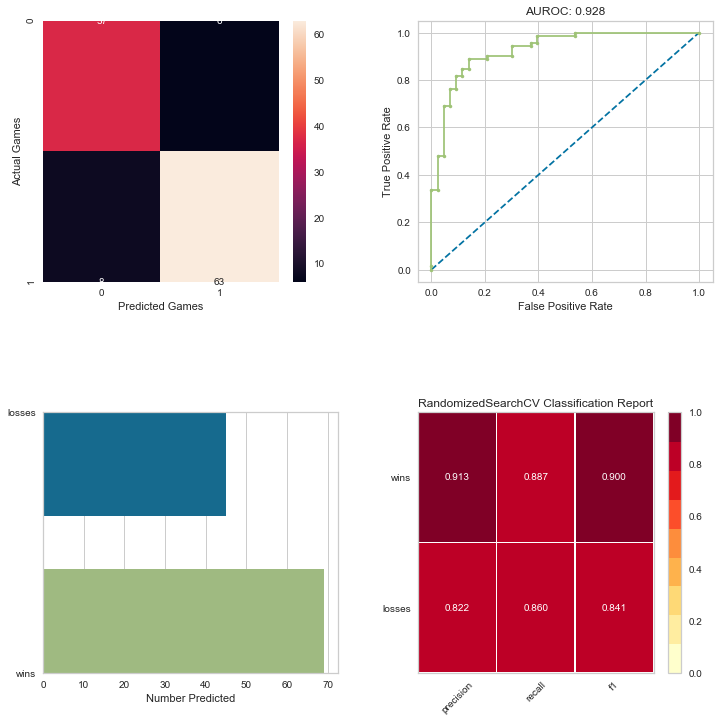

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)
Best Parameters: {'clf__n_estimators': 166, 'clf__max_features': 'sqrt'}

Training Accuracy: 1.0
Test Accuracy: 0.92



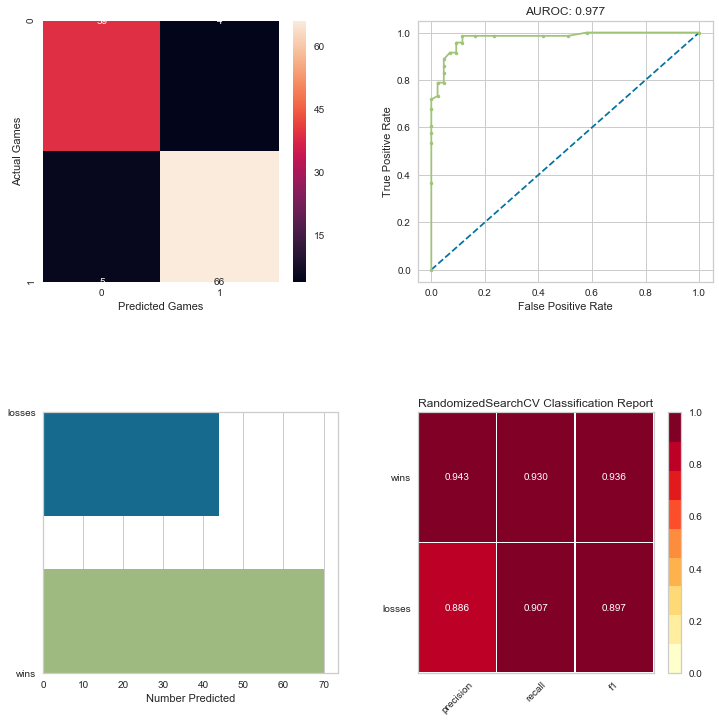

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)
Best Parameters: {'clf__penalty': 'none', 'clf__C': 1.0}

Training Accuracy: 0.94
Test Accuracy: 0.89



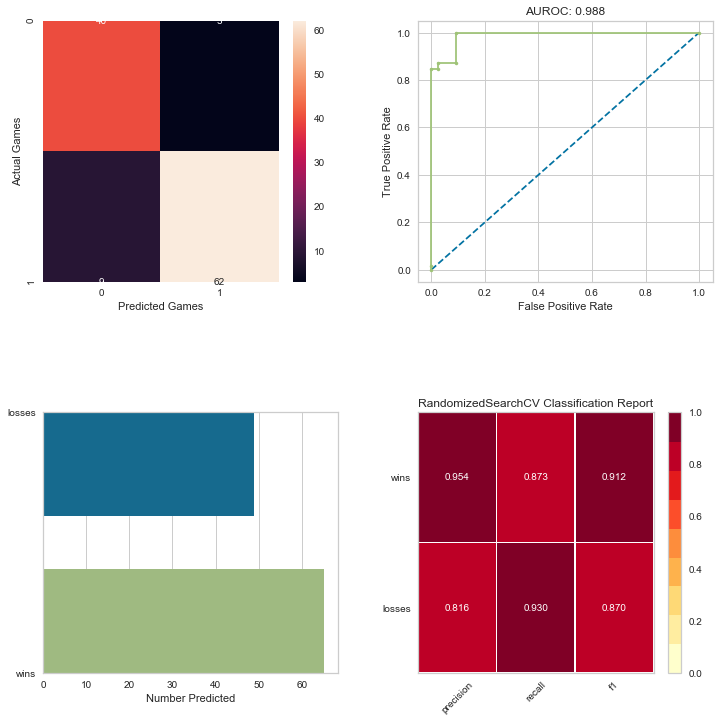

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(100,), learning_rate='constant',
              learning_rate_init=0.001, max_fun=15000, max_iter=200,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=None, shuffle=True, solver='adam',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)
Best Parameters: {'clf__hidden_layer_sizes': (17, 12, 10)}

Training Accuracy: 0.95
Test Accuracy: 0.92



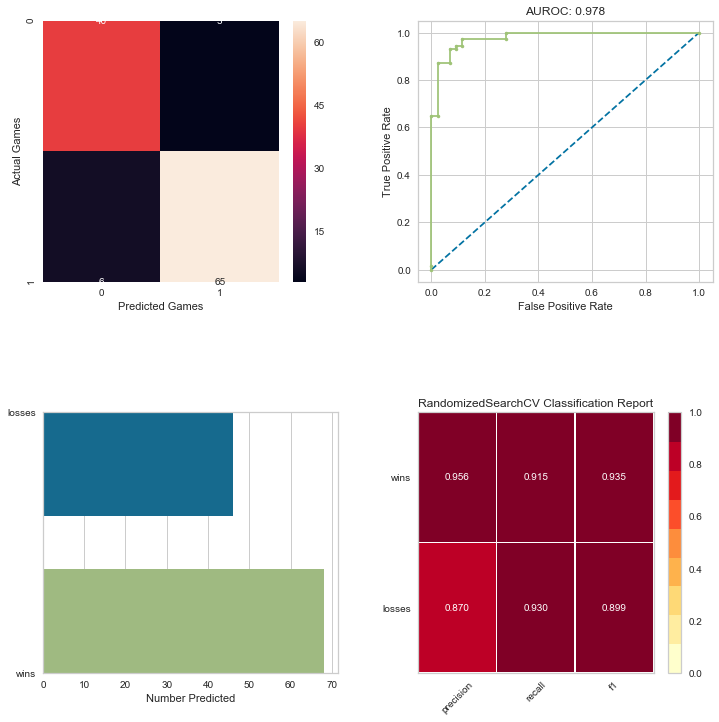

GaussianNB(priors=None, var_smoothing=1e-09)
Best Parameters: {'clf__var_smoothing': 1e-08}

Training Accuracy: 0.9
Test Accuracy: 0.89



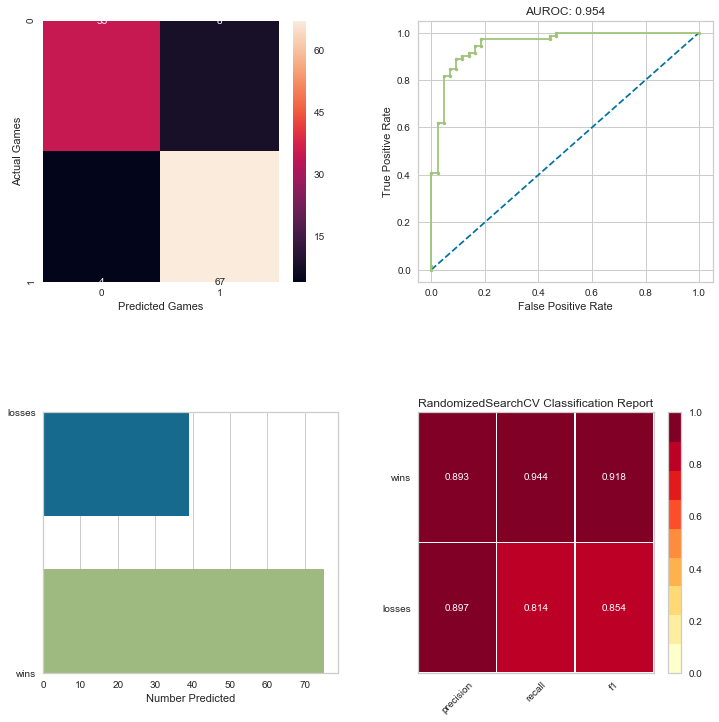

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=1.0,
                   n_estimators=50, random_state=None)
Best Parameters: {'clf__n_estimators': 122, 'clf__learning_rate': 0.9444444444444444}

Training Accuracy: 1.0
Test Accuracy: 0.9



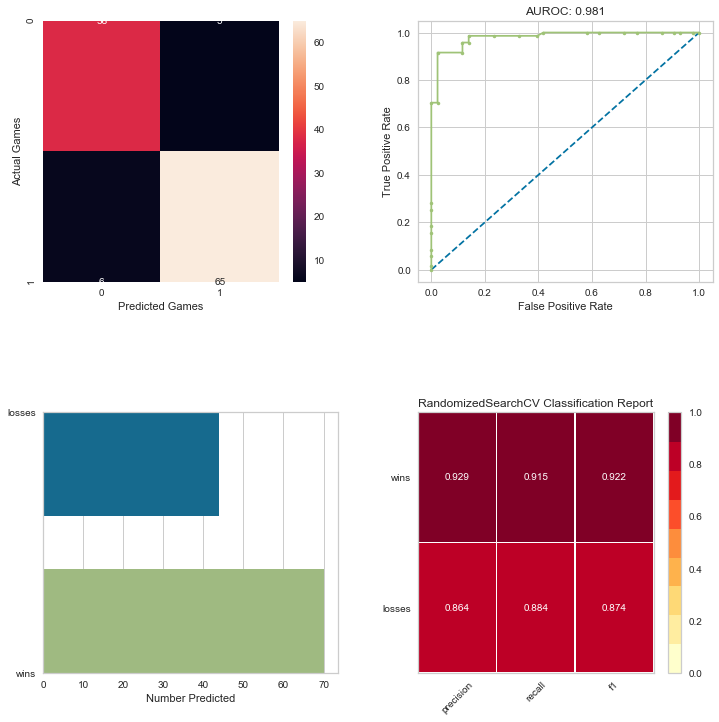

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)
Best Parameters: {'clf__n_estimators': 100, 'clf__learning_rate': 0.18}

Training Accuracy: 1.0
Test Accuracy: 0.93



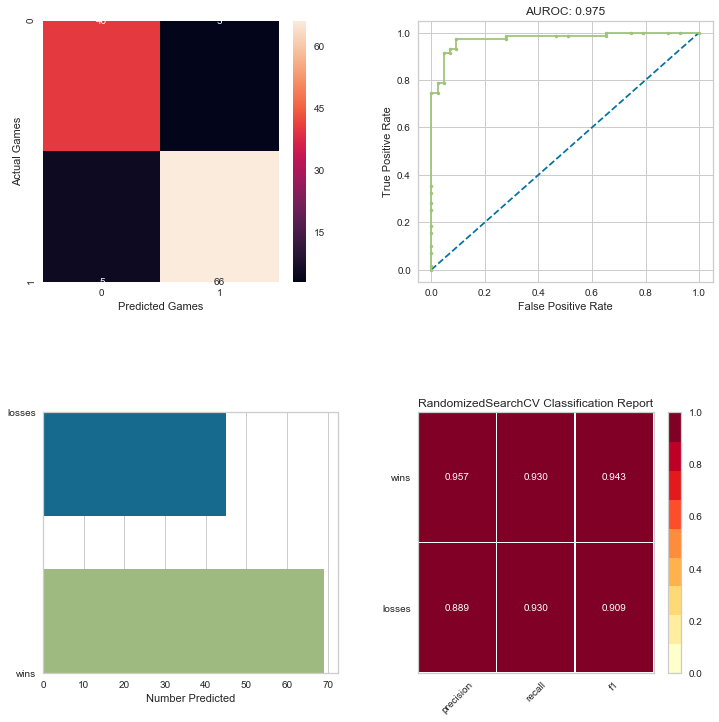

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)
Best Parameters: {'clf__max_depth': 2, 'clf__booster': 'dart'}

Training Accuracy: 0.97
Test Accuracy: 0.94



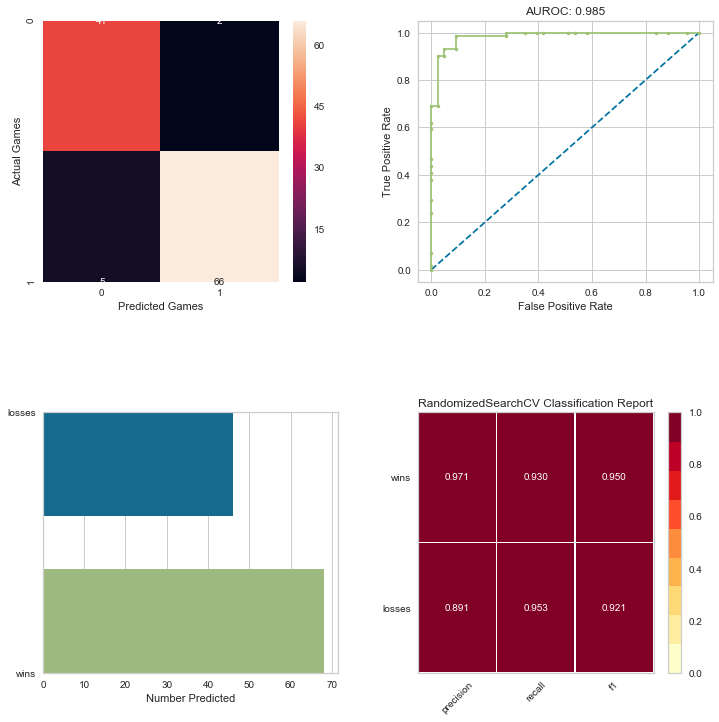

Model parameter search and testing took  31.69 seconds.


In [104]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB
import time

timer_start = time.time()

classifiers = [
    SVC(probability=True),
    RandomForestClassifier(),
    LogisticRegression(),
    MLPClassifier(),
    GaussianNB(),
    AdaBoostClassifier(),
    GradientBoostingClassifier(),
    XGBClassifier()
    ]

params=[
    { # SVC
        'clf__kernel': ['rbf', 'linear', 'sigmoid'],
        'clf__C': np.logspace(start=-10, stop=10, num=21) # default 1.0
    },
    { # RandomForestClassifier
        'clf__n_estimators': np.array(np.linspace(100,200,10, endpoint=True) , dtype=np.int32), # default 100
        'clf__max_features': ['sqrt', 'log2'] # The lower the greater the reduction of variance, but also the greater the increase in bias.
    },
    { # LogisticRegression
    'clf__C': np.logspace(start=-10, stop=10, num=21),
    'clf__penalty': ['none', 'l2']
    },
    { # Neural network multi-layered perceptron, MLPClassifier
      'clf__hidden_layer_sizes': tuple(map(tuple, np.random.randint(low=5, high=20, size=(10, 3)))) # from 5-20 nodes per 3 layers, 10 iterations
    },
    { # GaussianNB
        'clf__var_smoothing': [1e-8, 1e-9, 1e-10]
    },
    { # AdaBoostClassifier
        'clf__n_estimators': np.array(np.linspace(100,200,10, endpoint=True) , dtype=np.int32), # default 100
        'clf__learning_rate': np.linspace(0.5, 1.5, 10, endpoint=True) # default 1.0
    },
    { # GradientBoostingClassifier
        'clf__n_estimators': np.array(np.linspace(100,200,10, endpoint=True) , dtype=np.int32), # default 100
        'clf__learning_rate': np.linspace(0.02, 0.18, 9, endpoint=True) # default 0.1
    },
    { # XGBClassifier
#     'clf__learning_rate': np.logspace(start=0.01, stop=0.2, num=10, endpoint = True), # see last example in np.logspace documentation
    'clf__max_depth': [2,3,4,5],
    'clf__booster': ['gbtree', 'gblinear', 'dart']
    }
]

train_acc=[]
test_acc=[]
auc=[]
loggloss=[]
for i, classifier in enumerate(classifiers):
    print(classifier)
    current_clf, train, test, aucc, logloss = clfy_report(classifier, X_train, X_test, y_train, y_test, param_grid=params[i], cv=5)
    train_acc.append(train)
    test_acc.append(test)
    auc.append(aucc)
    loggloss.append(logloss)
end_timer = time.time()
print("Model parameter search and testing took ", round((end_timer - timer_start), 2), "seconds.")

In [4]:
    print(train_acc)
    print(test_acc)
    print(auc)
    print(loggloss)

[0.9384615384615385, 1.0, 0.9428571428571428, 0.9494505494505494, 0.9032967032967033, 1.0, 1.0, 0.9802197802197802]
[0.9210526315789473, 0.9210526315789473, 0.8947368421052632, 0.9298245614035088, 0.8947368421052632, 0.9385964912280702, 0.9298245614035088, 0.9473684210526315]
[0.9823124795283328, 0.9773992793973141, 0.9875532263347527, 0.9810022928267278, 0.9538159187684245, 0.9847690795938422, 0.9757615460203078, 0.9850966262692433]
[0.17175813390007633, 0.19173983793018073, 0.174744476110578, 0.20802286608489348, 0.45124367920611047, 0.5777835240966926, 0.24584023171386213, 0.1686560475474771]


In [72]:
from sklearn.ensemble import VotingClassifier
ensemble_clf = VotingClassifier(estimators=[
    ('clf', classifiers[0]), 
    ('clf' , classifiers[1]),
    ('clf' , classifiers[2]),
    ('clf', classifiers[3]),
    ('clf', classifiers[4]),
    ('clf', classifiers[5]), 
    ('clf', classifiers[6]),
    ('clf', classifiers[7])], 
                                voting='soft', 
                                # weights = [1,2,3], 
                                n_jobs=-1)

In [81]:
ensemble_clf.estimators[7][1]

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [83]:
def clfy_report_ensemble(ensemble_clf, X_train, X_test, y_train, y_test, param_grid, clf_label='clf', cv=10):
    # Create pipeline steps for encoding categorical variables, feature scaling and normalization 
    pipe = create_pipe_ensemble(X_train, ensemble_clf, clf_label='clf')
    
    # Instantiate grid search using 10-fold cross validation:
    search = RandomizedSearchCV(pipe, param_grid, cv=cv, n_iter=5)
    
    # Learn relationship between predictors (basketball/tourney features) and outcome,
    # and the best parameters for defining such:
    search.fit(X_train, y_train)
    
    # Predictions on the test set, new data that haven't been introduced to the model:
    predicted = search.predict(X_test)
    
    # Predictions as probabilities:
    probabilities = search.predict_proba(X_test)[:, 1]

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import VotingClassifier
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])
numeric_features = X_train.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X_train.select_dtypes(include=['object']).columns
preprocessor = ColumnTransformer(
    transformers=[
    ('num', numeric_transformer, numeric_features),
    ('cat', categorical_transformer, categorical_features)])
p5 =  Pipeline (steps=[('preprocessor', preprocessor),
                      ('randomforestclassifier', RandomForestClassifier())])
p6 = Pipeline (steps=[('preprocessor', preprocessor),
                      ('logisticregression', LogisticRegression())])
# p1 = Pipeline([['clf1', RandomForestClassifier()]])
# p2 = Pipeline([['clf2', AdaBoostClassifier()]])
# p3 = Pipeline([['clf3', VotingClassifier(estimators=[("p1",p1), ("p2",p2)])]])
# p7 = Pipeline(steps=[('preprocessor', preprocessor),
#                       ('p7', VotingClassifier(estimators=[('p5', create_pipe (X_train, RandomForestClassifier(), clf_label='clfy')),
#                                                           ('p6', p6)]))])
p7 = Pipeline(steps=[('p7', VotingClassifier(estimators=[
    ('randomforestclassifier', p5), ('logisticregression', p6)                                    
]))])

params=[
    { # RandomForestClassifier
        'p7__randomforestclassifier__randomforestclassifier__n_estimators': np.array(np.linspace(100,200,10, endpoint=True) , dtype=np.int32), # default 100
        'p7__randomforestclassifier__randomforestclassifier__max_features': ['sqrt', 'log2'] # The lower the greater the reduction of variance, but also the greater the increase in bias.
    },
    { # LogisticRegression
        'p7__logisticregression__logisticregression__C': np.logspace(start=-10, stop=10, num=21),
        'p7__logisticregression__logisticregression__penalty': ['none', 'l2']
    }
]

search = RandomizedSearchCV(p7, params, cv=5, n_iter=5)

# Learn relationship between predictors (basketball/tourney features) and outcome,
# and the best parameters for defining such:
search = search.fit(X_train, y_train)

In [150]:
search

RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=Pipeline(memory=None,
                                      steps=[('p7',
                                              VotingClassifier(estimators=[('randomforestclassifier',
                                                                            Pipeline(memory=None,
                                                                                     steps=[('preprocessor',
                                                                                             ColumnTransformer(n_jobs=None,
                                                                                                               remainder='drop',
                                                                                                               sparse_threshold=0.3,
                                                                                                               transformer_weights=None,
                       

In [138]:
p7[1].estimators[0][1][1]

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

['memory',
 'p7',
 'p7__estimators',
 'p7__flatten_transform',
 'p7__logisticregression',
 'p7__logisticregression__logisticregression',
 'p7__logisticregression__logisticregression__C',
 'p7__logisticregression__logisticregression__class_weight',
 'p7__logisticregression__logisticregression__dual',
 'p7__logisticregression__logisticregression__fit_intercept',
 'p7__logisticregression__logisticregression__intercept_scaling',
 'p7__logisticregression__logisticregression__l1_ratio',
 'p7__logisticregression__logisticregression__max_iter',
 'p7__logisticregression__logisticregression__multi_class',
 'p7__logisticregression__logisticregression__n_jobs',
 'p7__logisticregression__logisticregression__penalty',
 'p7__logisticregression__logisticregression__random_state',
 'p7__logisticregression__logisticregression__solver',
 'p7__logisticregression__logisticregression__tol',
 'p7__logisticregression__logisticregression__verbose',
 'p7__logisticregression__logisticregression__warm_start',
 'p

# Ensemble

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.ensemble import VotingClassifier

def create_pipe_ensemble(X_train, ensemble_clf, clf_label='clf'):
    """
    https://medium.com/vickdata/a-simple-guide-to-scikit-learn-pipelines-4ac0d974bdcf
    Returns an sklearn model pipeline.
    """
    pipe = Pipeline([(clf_label, VotingClassifier(estimators=[
                          (clf_label+str(1), create_pipe(X_train, ensemble_clf.estimators[0][1])),
                          (clf_label+str(2), create_pipe(X_train, ensemble_clf.estimators[1][1])),
                          (clf_label+str(3), create_pipe(X_train, ensemble_clf.estimators[2][1])),
                          (clf_label+str(4), create_pipe(X_train, ensemble_clf.estimators[3][1])),
                          (clf_label+str(5), create_pipe(X_train, ensemble_clf.estimators[4][1])),
                          (clf_label+str(6), create_pipe(X_train, ensemble_clf.estimators[5][1])),
                          (clf_label+str(7), create_pipe(X_train, ensemble_clf.estimators[6][1])),
                          (clf_label+str(8), create_pipe(X_train, ensemble_clf.estimators[7][1]))
                                           ]))])
    return pipe


In [1]:
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])
numeric_features = X_train.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X_train.select_dtypes(include=['object']).columns
preprocessor = ColumnTransformer(
    transformers=[
    ('num', numeric_transformer, numeric_features),
    ('cat', categorical_transformer, categorical_features)])

pipeline_objects=[]
for i in range(0,8):
    pipeline_objects.append(Pipeline (steps=[('preprocessor', preprocessor),
        ('clf'+str(i+1), classifiers[i])]))

import pprint as pp
pp.pprint(sorted(p7.get_params().keys()))
    


NameError: name 'Pipeline' is not defined

In [ ]:
ensemble_params=[
    { # SVC
        'clf__kernel': ['rbf', 'linear', 'sigmoid'],
        'clf__C': np.logspace(start=-10, stop=10, num=21) # default 1.0
    },
    { # RandomForestClassifier
        'clf__n_estimators': np.array(np.linspace(100,200,10, endpoint=True) , dtype=np.int32), # default 100
        'clf__max_features': ['sqrt', 'log2'] # The lower the greater the reduction of variance, but also the greater the increase in bias.
    },
    { # LogisticRegression
    'clf__C': np.logspace(start=-10, stop=10, num=21),
    'clf__penalty': ['none', 'l2']
    },
    { # Neural network multi-layered perceptron, MLPClassifier
      'clf__hidden_layer_sizes': tuple(map(tuple, np.random.randint(low=5, high=20, size=(10, 3)))) # from 5-20 nodes per 3 layers, 10 iterations
    },
    { # GaussianNB
        'clf__var_smoothing': [1e-8, 1e-9, 1e-10]
    },
    { # AdaBoostClassifier
        'clf__n_estimators': np.array(np.linspace(100,200,10, endpoint=True) , dtype=np.int32), # default 100
        'clf__learning_rate': np.linspace(0.5, 1.5, 10, endpoint=True) # default 1.0
    },
    { # GradientBoostingClassifier
        'clf__n_estimators': np.array(np.linspace(100,200,10, endpoint=True) , dtype=np.int32), # default 100
        'clf__learning_rate': np.linspace(0.02, 0.18, 9, endpoint=True) # default 0.1
    },
    { # XGBClassifier
#     'clf__learning_rate': np.logspace(start=0.01, stop=0.2, num=10, endpoint = True), # see last example in np.logspace documentation
    'clf__max_depth': [2,3,4,5],
    'clf__booster': ['gbtree', 'gblinear', 'dart']
    }
]